# This code is meant to take the ImageJ raw files and convert them to .nii files
## It will walk you through opening the files, zero padding them, renaming, and saving


### First import libraries
 For those new to Jupyter Notebook, use shift + enter to run the cell or the play button in the toolbar above


In [2]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Here we are pre-defining some functions to use later

In [3]:
# figure out difference that needs to be made up in rows/columns
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

#after calculating the padding, add in the padding to rows and columns to meet new expected size
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [4]:
def gather_by_name(orignal_path, new_path, phrase):
    n=0
    file_list=[]
    for root, dirs, files in os.walk(os.path.normpath(original_path), topdown=True):
        for name in files:
            if phrase in name:
                file_list.append(os.path.join(root,name))                
                
    for j in range(len(file_list)):
        filename = file_list[j]
        shutil.copy(filename, new_path)

   

    print('copied and moved '+ str(len(file_list))+' files')

In [5]:
def gather_filenames(path):
    raw_path = path
    patient_folders = []
    pt_fnames = []

    import os
    for root, dirs, files in os.walk(os.path.normpath(raw_path), topdown=True):
        for name in files: 
            #print(os.path.join(root, name))
            pt_fnames.append(os.path.join(root, name))
    print('\nPatient Folders have been identified\n')
    #sort through and get only the files with ROI in them
    #this eliminates the tiff and 3D files 
    #%%
    ROI_list = []
    for j in range(len(pt_fnames)):
        ROI_name = 'ROI'
        filename = os.path.basename(pt_fnames[j])
        if ROI_name in filename:
            ROI_list.append(pt_fnames[j])
    print('\nFilenames have been found and added\n')
    print('copied and moved '+ str(len(ROI_list))+' files')
    
    return ROI_list

In [6]:
def convert_NPY_NII(ROI_list):
    #new_size= new_size
    print('Converting', str(len(ROI_list)), 'files')
    for i in range(len(ROI_list)): # loop through all the available files from the list that had our keyword
        orig_fname = os.path.basename(ROI_list[i])# grab the ith filename in the list
        print(orig_fname)
        #extract information from the filename
        if orig_fname[0].isdigit(): 
            orig_fname = orig_fname
        else:
            orig_fname = orig_fname[3:]
        num_slice = int(orig_fname[-3:])
        #print(num_slice)
        if num_slice < 15:
            orig_fname = this_list[2]
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-7:-4]))
            #print(num_width)
            num_height = int((orig_fname[-11:-8]))
        elif num_slice < 50:
            #print('over 99')
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-8:-4]))
            #print(num_width)
            num_height = int((orig_fname[-12:-8]))
            #print(num_height)
        else:
            #print('less than 99')
            num_width = int((orig_fname[-7:-3]))
            #print(num_width)
            num_height = int((orig_fname[-11:-7]))
            #print(num_height)
        pt_numb =(orig_fname[0:6])
        if orig_fname[8].isdigit():
            yr_numb = (orig_fname[8])
        else:
            yr_numb = orig_fname[7]
        if 'Cyst' in orig_fname:
            img_type = 'C'
        elif 'Kidney' in orig_fname:
            img_type = 'M_K'
        elif 'Image' in orig_fname:
            img_type = 'M'
        if 'Right' in orig_fname:
            side = 'R'
        elif 'Left' in orig_fname:
            side = 'L'
        call_file = str(ROI_list[i]) #define our filename with path to open (working_path+'/'+orig_fname)
        resized = np.zeros((num_slice,new_size,new_size), dtype ='uint8')
        transposed = np.zeros((new_size, new_size, num_slice), dtype='uint8')
        with open(r'%s' %call_file, 'rb') as file: #read in raw uint8 and resize correctly
             data = np.fromfile(file, dtype = 'uint8').reshape(num_slice,num_width,num_height)
             for j in range(num_slice):
                 orig_slice = data[j]
                 re_slice = Image.fromarray(orig_slice)
                 resized[j] = resize_with_padding(re_slice, (new_size, new_size))
             for i in range(resized.shape[0]):
                 old_slice = resized[i,:,:]
                 transposed[:,:,i] = old_slice

                 # now we need to rename this resized array and save it as a .npy
        #new_fname = str('%s' %orig_fname + '_RESIZED_') #keep the original name for now 
        new_fname = str(pt_numb +'_'+ yr_numb +'_'+ str(num_slice) +'_'+ side + '_' +  img_type )
        file_name = "%s" %new_fname # add our extension
        np.save(os.path.join(new_path, file_name), transposed) # save in the new file folder
        converted_array = np.array(transposed, dtype=np.float32)
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(converted_array, affine)
        nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))


    print("complete --- nice job")

## FilePath Input
Fill in the filepaths for the raw data, the new path to store the npy files, and the final path for the images and annotations 
Make sure to fill out the new sizing as the complete size with zero padding

In [7]:
raw_path = r'C:\Users\UAB\data\Mayo\Original\issues solved'
new_path = r'C:\Users\UAB\data\Mayo\Original\issues converted'
final_path = r'C:\Users\UAB\data\Mayo\AllNII'
cyst_path = r'C:\Users\UAB\data\Mayo\Cyst'
new_size = 512

In [8]:
#remove .tif files

In [9]:
this_list = gather_filenames(raw_path)


Patient Folders have been identified


Filenames have been found and added

copied and moved 192 files


In [10]:
orig_fname = this_list[2]
num_slice = int(orig_fname[-3:])
num_width = int((orig_fname[-7:-4]))
            #print(num_width)
num_height = int((orig_fname[-11:-8]))

print(num_slice, num_width, num_height)

133 175 128


In [11]:
print(len(this_list))
print(this_list[1])

192
C:\Users\UAB\data\Mayo\Original\issues solved\313307 0  Cyst ROI Right 8bit 125 168 133


In [12]:
convert_NPY_NII(this_list) 

Converting 192 files
313307 0  Cyst ROI Left 8bit 128 175 133
313307 0  Cyst ROI Right 8bit 125 168 133
313307 0  Image ROI Left 8bit 128 175 133
313307 0  Image ROI Right 8bit 125 168 133
313307 0  Kidney ROI Left 8bit 128 175 133
313307 0  Kidney ROI Right 8bit 125 168 133
313307 1  Cyst ROI Left 8bit 133 188 140
313307 1  Cyst ROI Right 8bit 127 173 140
313307 1  Image ROI Left 8bit 133 188 140
313307 1  Image ROI Right 8bit 127 173 140
313307 1  Kidney ROI Left 8bit 133 188 140
313307 1  Kidney ROI Right 8bit 127 173 140
313307 2 Cyst ROI Left 8bit 147 200 147
313307 2 Cyst ROI Right 8bit 126 171 147
313307 2 Image ROI Left 8bit 147 200 147
313307 2 Image ROI Right 8bit 126 171 147
313307 2 Kidney ROI Left 8bit 147 200 147
313307 2 Kidney ROI Right 8bit 126 171 147
313307 3 Cyst ROI Left 8bit 138 195 161
313307 3 Cyst ROI Right 8bit 124 176 161
313307 3 Image ROI Left 8bit 138 195 161
313307 3 Image ROI Right 8bit 124 176 161
313307 3 Kidney ROI Left 8bit 138 195 161
313307 3 Kidne

## Re-assign Masks
Move the masks to a new location in the file structure desired

In [13]:
path = new_path
cyst_path = cyst_path
cyst_names=[]
for root, dirs, files in os.walk(os.path.normpath(path), topdown=True):
    for name in files:
        #print(os.path.join(root, name))
        cyst_names.append(os.path.join(root, name))

C_list = []
for j in range(len(cyst_names)):
    C_name = '_C'
    filename = os.path.basename(cyst_names[j])
    if C_name in filename:
        C_list.append(cyst_names[j])

for i in range(len(C_list)):
    shutil.move(C_list[i],cyst_path )

# Save as single slices


In [14]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of



In [15]:
data_path = r"C:\Users\UAB\data\Mayo\Original\issues converted"
new_path = r"C:\Users\UAB\data\Mayo\data"


labels = gather_set(data_path, '_K')


for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    file_name = labels[i][:-7]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_K')
        np.save(os.path.join(new_path, new_fname), save_slice)
        


In [16]:
images = gather_set(data_path, '_M.')
for i in range(len(images)):
    working_img = np.load(data_path + '\\' + images[i])
    file_name = images[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_M')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [17]:
data_path = r'C:\Users\UAB\data\Mayo\data'
final_path = r'C:\Users\UAB\data\Mayo\data'
kidney_non = gather_set(data_path, '_K')

In [ ]:
seg_list=kidney_non

for i in range(len(seg_list)):
    segment = nib.load(data_path+"\\"+seg_list[i])
    seg_data = segment.get_fdata()
    binarized = np.where(seg_data>1,1,seg_data)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(binarized, affine)
    nib.save(nifti_file, os.path.join(final_path, "%s" %seg_list[i]))
    

In [ ]:
import nibabel as nib
new_path = r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\TwoDim"
for i in range(len(images)):
    working_img = nib.load(data_path + '\\' + images[i])
    working_img = working_img.get_fdata()
    file_name = images[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_M')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [ ]:
for i in range(len(labels)):
    working_img = nib.load(data_path + '\\' + labels[i])
    working_img = working_img.get_fdata()
    file_name = labels[i][:-7]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_K')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [62]:
data_path = r"C:\Users\UAB\data\UAB\AllNPY"

images = gather_set(data_path, '_M.')
labels = gather_set(data_path, '_K')


## Binarize masks
first gather the set based on the naming convention above, then binarize and save in a different location

In [18]:
final_path = r"C:\Users\UAB\data\Mayo\data"
seg_list = gather_set(final_path, '_K')


for i in range(len(seg_list)):
    seg_data = np.load(final_path+"\\"+seg_list[i])
    file_name = seg_list[i][:-4]
    binarized = np.where(seg_data>1,1,seg_data)
    np.save(os.path.join(final_path, file_name), binarized)

In [18]:
print(len(seg_list))

864


check sizes and range


In [19]:
image_test = np.load(r"C:\Users\UAB\data\Mayo\data\359308_2_126_R_66_M.npy")
print(image_test.max(), image_test.shape)
label_test = np.load(r"C:\Users\UAB\data\Mayo\data\359308_2_126_R_66_K.npy")
print(label_test.max(), label_test.shape)

93 (512, 512)
1 (512, 512)


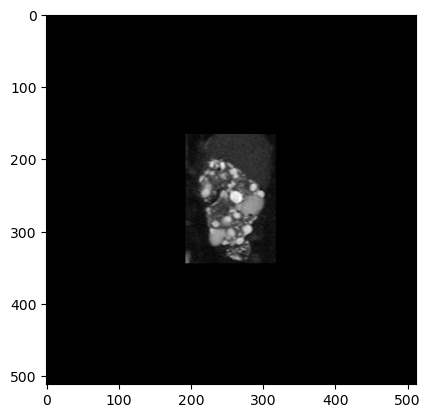

In [20]:
%matplotlib inline

plt.imshow(image_test, cmap='gray')

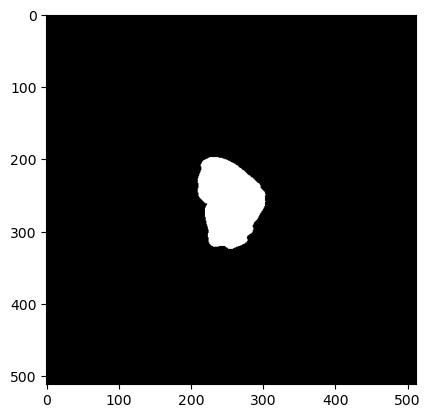

In [21]:
plt.imshow(label_test, cmap='gray')

In [119]:
def convert_NPY_NII_small(ROI_list):
    #new_size= new_size
    print('Converting', str(len(ROI_list)), 'files')
    for i in range(len(ROI_list)): # loop through all the available files from the list that had our keyword
        orig_fname = os.path.basename(ROI_list[i])# grab the ith filename in the list
        print(orig_fname)
        #extract information from the filename
        if orig_fname[0].isdigit(): 
            orig_fname = orig_fname
        else:
            orig_fname = orig_fname[3:]
        num_slice = int(orig_fname[-3:])
        #print(num_slice)
        if num_slice < 15:
            orig_fname = this_list[2]
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-7:-4]))
            #print(num_width)
            num_height = int((orig_fname[-11:-8]))
        elif num_slice < 50:
            #print('over 99')
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-8:-4]))
            #print(num_width)
            num_height = int((orig_fname[-12:-8]))
            #print(num_height)
        else:
            #print('less than 99')
            num_width = int((orig_fname[-7:-3]))
            #print(num_width)
            num_height = int((orig_fname[-10:-7]))
            #print(num_height)
        pt_numb =(orig_fname[0:6])
        yr_numb = (orig_fname[8])
        if 'Cyst' in orig_fname:
            img_type = 'C'
        elif 'Kidney' in orig_fname:
            img_type = 'M_K'
        elif 'Image' in orig_fname:
            img_type = 'M'
        if 'Right' in orig_fname:
            side = 'R'
        elif 'Left' in orig_fname:
            side = 'L'
        call_file = str(ROI_list[i]) #define our filename with path to open (working_path+'/'+orig_fname)
        resized = np.zeros((num_slice,new_size,new_size), dtype ='uint8')
        transposed = np.zeros((new_size, new_size, num_slice), dtype='uint8')
        with open(r'%s' %call_file, 'rb') as file: #read in raw uint8 and resize correctly
             data = np.fromfile(file, dtype = 'uint8').reshape(num_slice,num_width,num_height)
             for j in range(num_slice):
                 orig_slice = data[j]
                 re_slice = Image.fromarray(orig_slice)
                 resized[j] = resize_with_padding(re_slice, (new_size, new_size))
             for i in range(resized.shape[0]):
                 old_slice = resized[i,:,:]
                 transposed[:,:,i] = old_slice

                 # now we need to rename this resized array and save it as a .npy
        #new_fname = str('%s' %orig_fname + '_RESIZED_') #keep the original name for now 
        new_fname = str(pt_numb +'_'+ yr_numb +'_'+ str(num_slice) +'_'+ side + '_' +  img_type )
        file_name = "%s" %new_fname # add our extension
        np.save(os.path.join(new_path, file_name), transposed) # save in the new file folder
        converted_array = np.array(transposed, dtype=np.float32)
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(converted_array, affine)
        nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))


    print("complete --- nice job")

In [120]:
raw_path = r'C:\Users\UAB\data\Emory\issues'
new_path = r'C:\Users\UAB\data\Emory\npy'
final_path = r'C:\Users\UAB\data\Emory\nii'
cyst_path = r'C:\Users\UAB\data\Emory\c'
new_size = 512

this_list = gather_filenames(raw_path)


convert_NPY_NII_small(this_list) 



Patient Folders have been identified


Filenames have been found and added

copied and moved 18 files
Converting 18 files
246620 y0 Cyst ROI Left 8bit 98 131 90
246620 y0 Image ROI Left 8bit 98 131 90
246620 y0 Kidney ROI Left 8bit 98 131 90
246620 y1 Cyst ROI Left 8bit 99 130 90
246620 y1 Image ROI Left 8bit 99 130 90
246620 y1 Kidney ROI Left 8bit 99 130 90
246620 y3 Cyst ROI Left 8bit 94 131 90
246620 y3 Image ROI Left 8bit 94 131 90
246620 y3 Kidney ROI Left 8bit 94 131 90
265171 y2 Cyst ROI Left 8bit 98 142 90
265171 y2 Cyst ROI Right 8bit 99 146 90
265171 y2 Image ROI Left 8bit 98 142 90
265171 y2 Image ROI Right 8bit 99 146 90
265171 y2 Kidney ROI Left 8bit 98 142 90
265171 y2 Kidney ROI Right 8bit 99 146 90
265171 y3 Cyst ROI Left 8bit 95 141 96
265171 y3 Image ROI Left 8bit 95 141 96
265171 y3 Kidney ROI Left 8bit 95 141 96
complete --- nice job


In [121]:

    
data_path = r"C:\Users\UAB\data\Emory\npy"
new_path = r"C:\Users\UAB\data\Emory\new"


labels = gather_set(data_path, '_K')


for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    file_name = labels[i][:-7]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_K')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [122]:
images = gather_set(data_path, '_M.')
for i in range(len(images)):
    working_img = np.load(data_path + '\\' + images[i])
    file_name = images[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_M')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [ ]:
final_path = r"C:\Users\UAB\data\Emory\new"
seg_list = gather_set(final_path, '_K')


for i in range(len(seg_list)):
    seg_data = np.load(final_path+"\\"+seg_list[i])
    file_name = seg_list[i][:-4]
    binarized = np.where(seg_data>1,1,seg_data)
    np.save(os.path.join(final_path, file_name), binarized)

In [80]:
image_test = np.load(r"C:\Users\UAB\data\Mayo\Original\Pt 303868\new\303868_0_87_L_30_M.npy")
print(image_test.max(), image_test.shape)
label_test = np.load(r"C:\Users\UAB\data\Mayo\Original\Pt 303868\new\303868_0_87_L_30_K.npy")
print(label_test.max(), label_test.shape)

249 (512, 512)
1 (512, 512)


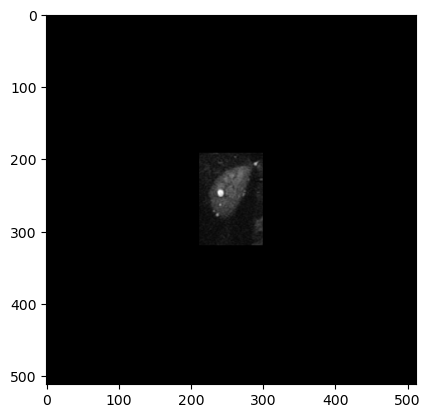

In [84]:
plt.imshow(image_test, cmap='gray')


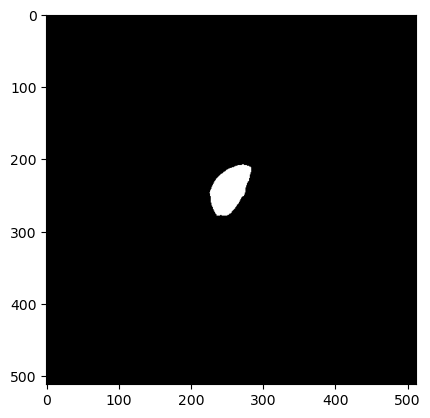

In [83]:
plt.imshow(label_test, cmap='gray')

In [3]:
import os

directory = os.path.abspath(r'')

for files in os.listdir(directory):
    os.rename(files, str('MA_'+files))

FileNotFoundError: [WinError 2] The system cannot find the file specified: '200922_0_144_L_0_K.npy' -> 'EM_200922_0_144_L_0_K.npy'